# Rainfall variability

Code to see what happens when you alter the rainfall statistics, either using historical alphas and lambdas or potential future conditions. 

Contents:
1. [Import model](#import)
2. [Previously used outputs](#import2)
3. [Run models with new alphas and lambdas](#run)
4. [Summary stats and figs for previous outputs](#prev)
5. [Translate alphas and lambdas into c.v. (coming up next!)](#cv)
6. [How to make more variable future climate](#future)
7. [Cultivars figure](#cultis)
8. [Presentation figures (black background)](#prez)

Last updated: 11 August 2020

## 1. Import model <a id='import'></a>

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import sys
from dateutil.relativedelta import *
from datetime import timedelta, datetime
import proplot as plot
import seaborn as sns
import scipy
from numpy.random import exponential, uniform

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from scripts import mkt

## 2. Import previously used outputs <a id='import2'></a>

In [109]:
lams = pd.read_csv('../output/2-rainfall-variability/lambda_by_month.csv',sep=',').drop('Unnamed: 0',axis=1)
alphs = pd.read_csv('../output/2-rainfall-variability/alpha_by_month.csv',sep=',').drop('Unnamed: 0',axis=1)

#r0 = pd.read_csv('../output/2-rainfall-variability/r0_output.csv',sep=',').drop('Unnamed: 0',axis=1)
#r1 = pd.read_csv('../output/2-rainfall-variability/r25_output.csv',sep=',').drop('Unnamed: 0',axis=1)
#r2 = pd.read_csv('../output/2-rainfall-variability/r50_output.csv',sep=',').drop('Unnamed: 0',axis=1)
#r3 = pd.read_csv('../output/2-rainfall-variability/r75_output.csv',sep=',').drop('Unnamed: 0',axis=1)
r1930 = pd.read_csv('../output/2-rainfall-variability/r1930_output.csv',sep=',').drop('Unnamed: 0',axis=1)
t1940 = pd.read_csv('../output/2-rainfall-variability/t1940_output.csv',sep=',').drop('Unnamed: 0',axis=1)
t1975 = pd.read_csv('../output/2-rainfall-variability/t1975_output.csv',sep=',').drop('Unnamed: 0',axis=1)
t2010 = pd.read_csv('../output/2-rainfall-variability/t2010_output.csv',sep=',').drop('Unnamed: 0',axis=1)

In [110]:
# new stuff
# run models with new alpha and lambda values
r0_l = lams.query('Cat == "first5"')['Mean'].values
r1_l = lams.query('Cat == "mid5"')['Mean'].values
r2_l = lams.query('Cat == "last5"')['Mean'].values

In [111]:
r0_a = alphs.query('Cat == "first5"')['Mean'].values
r1_a = alphs.query('Cat == "mid5"')['Mean'].values
r2_a = alphs.query('Cat == "last5"')['Mean'].values

## 3. Run models with new alphas and lambdas <a id='run'></a>

In [124]:
# copying the whole climate object
alphas=r2_a
lambdas=r2_l


#%% Climate Class Definition

default_climate = {
    'alpha_r': alphas,
    'lambda_r': lambdas,
    'ET_max': 6.5
}

datetimes = np.arange(
    datetime(2018,1,1), datetime(2019,1,1), timedelta(days=1)
    ).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

class Climate():

    """ Creates a years worth of daily rainfall timeseries for use in ecohydrological modeling

    Usage: climate = Climate(alpha_r, lambda_r, ET_max)

        alpha_r = average storm depth [mm]
        lambda_r = storm frequency [day^-1]
      
    Default values:
        alpha_r = 10
        lambda_r = 0.25
        t_seas = 180
        ET_max = 6.5

    Note: lambda must either be a single value (constant rainfall probability all season),
    or have length of tseas (discrete rainfall probabilities each day.

    """
    def __init__(self, alpha_r=alphas, lambda_r=lambdas, ET_max=6.5, **kwargs): # Reverted this
       
        # Unpack the dictionary:
        self.ET_max = ET_max
        
        # Check to ensure that lambda_r is either:
        # 1. a scalar, which means we have constant climate parameters
        # 2. has length of 365, which means we have specified daily values.
        # 3. has length of 12, which means we have specified monthly values.
        if isinstance(lambda_r, (float, int)):
            if isinstance(alpha_r, (float, int)):
                # We have a constant value:
                lambda_r_list = [lambda_r] * 365
                alpha_r_list = [alpha_r] * 365
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        elif len(lambda_r) == 365:
            if len(alpha_r) == 365:
                lambda_r_list = lambda_r
                alpha_r_list = alpha_r
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        elif len(lambda_r) == 12:
            if len(alpha_r) == 12:
                # We have monthly values (remember that python is zero-indexed)
                lambda_r_list = np.array(
                    [lambda_r[month_value-1] for month_value in month_value_by_day]
                    )
                alpha_r_list = np.array(
                    [alpha_r[month_value-1] for month_value in month_value_by_day]
                    )
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        else:
            raise ValueError(
                "lambda_r & alpha_r values should be a constant, have length of t_sim, or have length of 12"
            )
      
        # Set the rainfall parameters for this instance
        self.alpha_r = alpha_r_list 
        self.lambda_r = lambda_r_list 
        
        # Use the static method, generate, to create this instance's rainfall.
        self.rainfall = self.generate(self.alpha_r, self.lambda_r)

        # Assign any other passed parameters (e.g. site, etc...)
        for key, value in kwargs.items():
            self.key = value
        #print(lambda_r_list, alpha_r_list)

    def calc_E(self, s, q=1.5, LAI=None, sh=None): 
        """ Determines the daily evaporation as a function of relative soil moisture

        Usage: calc_E(s)

            TODO: Update parameters.

            s = relative soil moisture [0-1]
            E_max_p = E_max * exp(-k * LAI)
            E = E_max * [(s-sh)/(1-sh)]^q

        """
        if LAI == None:
            raise ValueError("Climate calc_E expects LAI that's not None.")

        k = 0.5
        E_max_p = self.ET_max*exp(-k*LAI) 
        if s >= sh:
            return pow((s-sh)/(1-sh), q)*E_max_p
        else:
            return 0

    @staticmethod # Static methods can be called without instancing the class.
    def generate(alpha_r=alphas, lambda_r=lambdas, t_sim=365, doy_start=1): #changed this
        """ Makes a time series of rainfall based on parameters

        Usage:
            generate(alpha_r, lambda_r, t_seas)

            alpha_r = average storm depth [mm]
            lambda_r = storm frequency [day^-1]
            t_seas = lenght of growing season [days]

        Note: lambda must either be a single value (constant rainfall probability all season),
        or have length of tseas (discrete rainfall probabilities each day.

        """
        # Force doy to be in [1,365]:
        doys = np.arange(doy_start, doy_start + t_sim)
        while (doys - 365 > 0).any() == True:
            doys = doys - 365 * ((doys - 365) > 0)

        amounts = [exponential(scale=alpha_r[doy-1], size=1)[0] for doy in doys]
        rain_days = [(uniform(low=0, high=1, size=1) <= lambda_r[doy-1] ).astype(int) for doy in doys]
        return np.multiply(amounts, [v[0] for v in rain_days])



0.9343848966822587
m 0.027663781543337797
b -0.663913202486896


<Figure size 500x400 with 0 Axes>

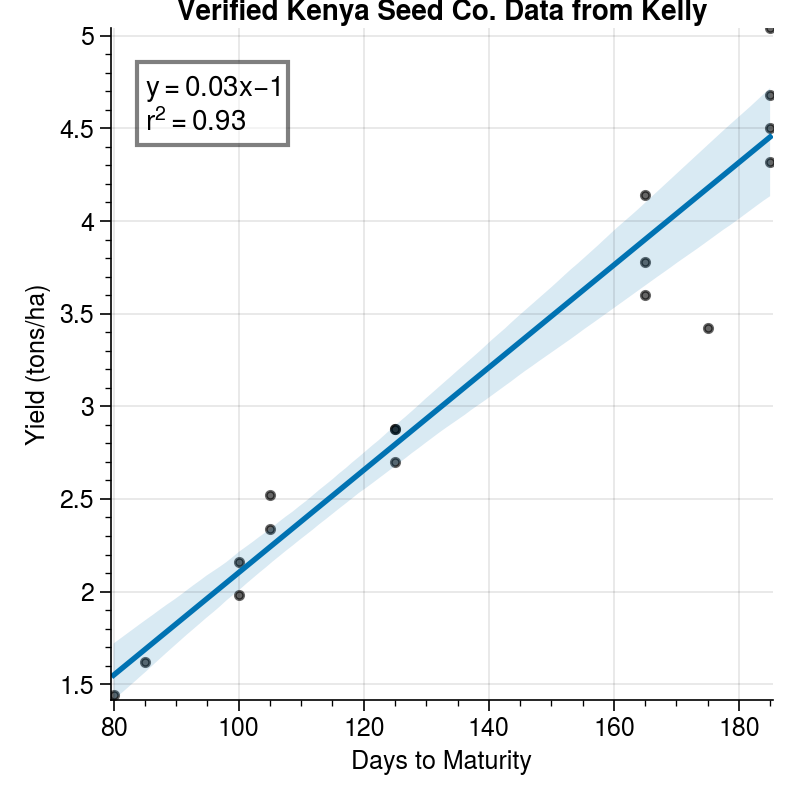

In [125]:
def evolved_calc_yield(dtm=None, m = None, b = None):
    yield_kg_ha = m*dtm + b

    if dtm > 185:
        raise ValueError("days to maturity, {dtm} is larger than 175".format(
                dtm=dtm))
    if dtm < 68:
        raise ValueError("days to maturity, {dtm} is less than 68".format(
                dtm=dtm))

    return yield_kg_ha

## Part 0. Account for different maximum yields
# verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')

# convert to metric tons
verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                             'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                             85, 4.8, 'Days to Maturity', 'Yield (tons/ha)', 
                             'Verified Kenya Seed Co. Data from Kelly', positive=False)
#evolved_calc_yield(100, m, b)
#evolved_calc_yield(175,m,b)
    
def run(n_sim = 100, station = 'JACOBSON FARM', texture = 'clay loam', lgp=180, pd_sim=60, 
        alpha_r=alphas, lambda_r=lambdas): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(alpha_r=alphas, lambda_r=lambdas) # alpha_r=r2_a, lambda_r=r2_l #Climate(station=station), what it was previously
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(alpha_r=alphas, lambda_r=lambdas), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 60 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    i=lgp
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return output, avg_stress, total_stress, total_rf, x

In [126]:
# # woud be nice to get the above in a loop so that I dont have to manually save
# # this takes a while, so let's comment it out!

# alphas=[r0_a, r1_a, r2_a]
# lambdas=[r0_l,r1_l,r2_l]
# r0=[]
# r1=[]
# r2=[]
# output = [r0,r1,r2]

# for i, l, r in zip(alphas, lambdas, output):
#     o, avg_stress, total_stress, total_rf, var = run(alpha_r=i, lambda_r=l)
#     r.append(var)

In [127]:
# try this another way
#o0, avg_stress0, total_stress0, total_rf0, r0 = run(alpha_r=r0_a, lambda_r=r0_l)
#o1, avg_stress1, total_stress1, total_rf1, r1 = run(alpha_r=r1_a, lambda_r=r1_l)


In [134]:
o, avg_stress, total_stress, total_rf, r2 = run()
r2

[(0.2437031048418085, 0.37283947066921413, 2.7065535821805935),
 (0.2205956862382261, 0.21683411493542903, 3.3798052213600926),
 (0.34769383965880873, 0.3376633921589622, 2.858358322508525),
 (0.2700905672332283, 0.4070696022817319, 2.5588311395178973),
 (0.29604200442936657, 0.6711732534108227, 1.4190740125935422),
 (0.19456717691467623, 0.2839107391288455, 3.0903315236371305),
 (0.17930777267944076, 0.2233421016028385, 3.3517195657684438),
 (0.45162519008767854, 0.7854234946405823, 0.9260193874956236),
 (0.2665735784182409, 0.47911006660441835, 2.2479356547804),
 (0.4135001990537573, 0.6292822642374157, 1.5998574029790242),
 (0.45697098695989286, 0.7799101954938357, 0.9498124019749992),
 (0.37413158246767303, 0.49947158696461363, 2.1600641397659994),
 (0.3430460878618407, 0.37207777992418695, 2.7098407099860804),
 (0.5418418169156232, 0.6968170461822906, 1.3084064945653056),
 (0.3158345170518054, 0.516420662664809, 2.086919259937603),
 (0.3901201069268588, 0.6824577158925402, 1.37037

In [128]:
r2 = pd.DataFrame(r2, columns=['Avg_StaticStress','DynamicStress','Yield'])
len(r2.loc[r2['Yield'] == 0].count(axis=1))/len(r2)*100

7.000000000000001

In [133]:
r2.loc[r2['Yield'] == 0]

,Avg_StaticStress,DynamicStress,Yield
13,0.476946,1.0,0.0
30,0.430029,1.0,0.0
39,0.420126,1.0,0.0
45,0.408938,1.0,0.0
47,0.372052,1.0,0.0
64,0.476460,1.0,0.0
74,0.543820,1.0,0.0


In [117]:
o, avg_stress, total_stress, total_rf, r0 = run()
r0 = pd.DataFrame(r0, columns=['Avg_StaticStress','DynamicStress','Yield'])
len(r0.loc[r0['Yield'] == 0].count(axis=1))/len(r)*100

3.0

In [118]:
o, avg_stress, total_stress, total_rf, r1 = run()
r1 = pd.DataFrame(r, columns=['Avg_StaticStress','DynamicStress','Yield'])
len(r1.loc[r1['Yield'] == 0].count(axis=1))/len(r1)*100

20.0

In [122]:
r2

,Avg_StaticStress,DynamicStress,Yield
0,0.422735,0.587898,1.778454
1,0.416222,0.725579,1.184282
2,0.312452,0.759496,1.037910
3,0.409536,0.491597,2.194049
4,0.263235,0.338296,2.855627
...,...,...,...
95,0.317480,0.379406,2.678215
96,0.280566,0.313299,2.963506
97,0.138884,0.209966,3.409446
98,0.194346,0.275064,3.128510


In [89]:
# because output is a list (double square bracket) have to take first element, r0[0]
r0 = pd.DataFrame(r0, columns=['Avg_StaticStress','DynamicStress','Yield'])
r1 = pd.DataFrame(r1, columns=['Avg_StaticStress','DynamicStress','Yield'])
r2 = pd.DataFrame(r2, columns=['Avg_StaticStress','DynamicStress','Yield'])
r2

print(r0.Yield.mean(), np.nanmean(r0.Yield))
r2

2.232774505547353 2.232774505547353


,Avg_StaticStress,DynamicStress,Yield
0,0.404910,0.683392,1.366343
1,0.237246,0.255544,3.212748
2,0.310801,0.441909,2.408480
3,0.510970,0.918022,0.353781
4,0.324543,0.494654,2.180853
...,...,...,...
95,0.416084,1.000000,0.000000
96,0.135646,0.182251,3.529051
97,0.323731,0.456148,2.347032
98,0.196491,0.264206,3.175369


In [90]:
df = pd.DataFrame({'Rainfall Climatology':['1935-1940','1972-1977','2010-2015'],
            'Maize Variety':[180,180,180],
            'Average Yield (t/ha)': [np.nanmean(r0.Yield), np.nanmean(r1.Yield), np.nanmean(r2.Yield)],
            'Probability of Crop Failure (%)':[len(r0.loc[r0['Yield'] == 0].count(axis=1))/len(r0)*100,
             len(r1.loc[r1['Yield'] == 0].count(axis=1))/len(r1)*100,
             len(r2.loc[r2['Yield'] == 0].count(axis=1))/len(r2)*100]})
df

,Rainfall Climatology,Maize Variety,Average Yield (t/ha),Probability of Crop Failure (%)
0,1935-1940,180,2.232775,8.0
1,1972-1977,180,2.301230,8.0
2,2010-2015,180,2.341032,9.0


In [126]:
# Got it!
# Write these out

#r0.to_csv('../output/2-rainfall-variability/t1930s.csv',sep=',')
#r1.to_csv('../output/2-rainfall-variability/t1975s.csv',sep=',')
#r2.to_csv('../output/2-rainfall-variability/t2010s.csv',sep=',')

In [123]:
# Next, make a plot -- this is not exactly when I envisioned.

# Can I get these three on the same plot?

# # I dont know how to do this with proplot - to get nice abcd, put in an issue
# fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(8,3), sharey=True, sharex=True) 


# # this is so janky
# sns.kdeplot(r0.DynamicStress, r0.Yield, xlim=(0,1),alpha=0.5, kind='kde',cmap="grays", shade=True, 
#                 shade_lowest=False, cbar=True, ax=axes[0])
# ax1 = axes[0]
# #ax1.text(e_rf,e_y, "x", size=12, color='k')
# #ax1.set(ylim=(-0.5,4.5))
# #ax1.set(xlim=(0,700))
# ax1.set(ylabel='Yield (t/ha)')
# ax1.set(xlabel='')


# #plt.show()
# ax2 = axes[1]
# sns.kdeplot(r1.DynamicStress, r1.Yield, xlim=(0,1),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="grays", 
#                   shade=True, shade_lowest=False, cbar=True,ax=ax2)
# #ax2.text(m_rf,m_y,"x",size=12,color='k')
# #ax2.set(ylim=(-0.5,4.5))
# #ax2.set(xlim=(0,700))
# ax2.set(ylabel='')
# ax2.set(xlabel='Rainfall (mm)')


# ax3 = axes[2]
# #plt.show()
# sns.kdeplot(r2.DynamicStress, r2.Yield,xlim=(0,1),ylim=(-0.5,4.5), alpha=0.5,kind='kde',cmap="grays", shade=True, shade_lowest=False, cbar=True, ax=ax3) #greens
# #ax3.text(l_rf,l_y, "x", size=12, color='k')
# #ax3.set(ylim=(-0.5,4.5))
# #ax3.set(xlim=(0,700))
# ax3.set(ylabel='')
# ax3.set(xlabel='')
# fig.tight_layout()
# #plt.savefig('../output/4-cultivar-analysis/varietiesPDFa.png')

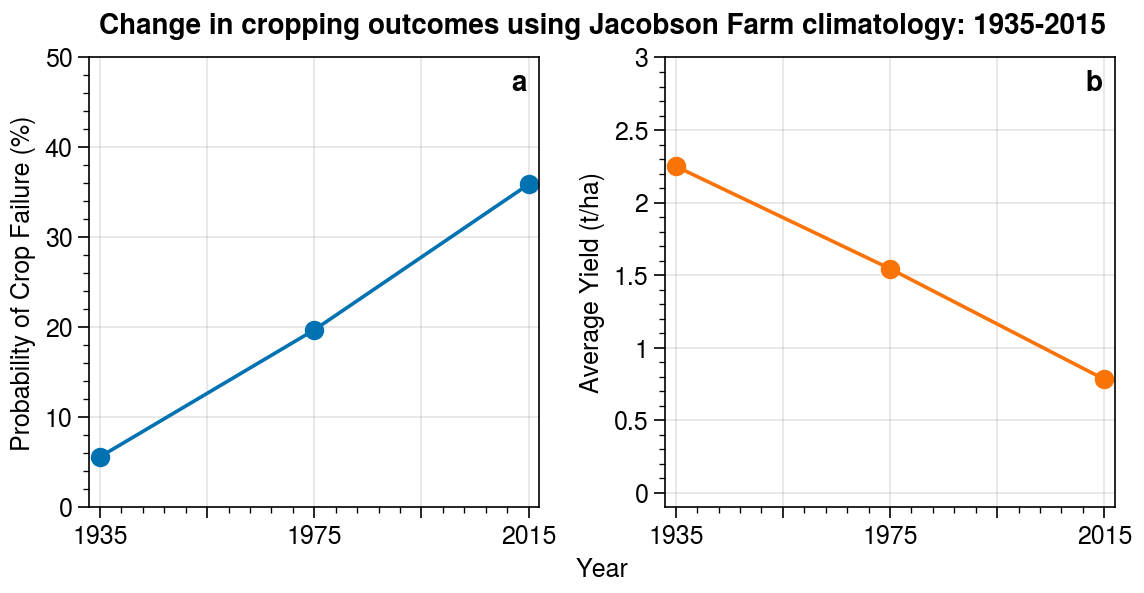

In [178]:
# Make final figure for manuscript

f, ax = plot.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
ax.format(
         suptitle='Change in cropping outcomes using Jacobson Farm climatology: 1935-2015',
         #title='reference', titleweight='bold',
         #titleloc='uc', titlecolor='red9'
        xlabel='Year', abc=True, abcloc='ur'
     )

#ax.format(suptitle='')
# Consider adding some kind of error bar: yerr=df['Probability of Crop Failure (%)']
df['Probability of Crop Failure (%)'].plot(marker='o',markersize=6, ax=ax[0])
ax[0].set(ylim=(0,50))
#ax[0].set(ylabel='Probability of Crop Failure (%)')
ax[0].format(ylabel='Probability of Crop Failure (%)')
ax[0].set(xlim=(-0.05,2.05))
ax[0].set_xticklabels(['','1935-1940', '',
                      '1972-1977','','2010-2015'])

df['Average Yield (t/ha)'].plot(marker='o',markersize=6, ax=ax[1], color='orange')
ax[1].set(ylim=(-0.1,3))
ax[1].set(xlim=(-0.05,2.05))
#ax[1].set(ylabel='Average Yield (t/ha)')
ax[1].format(ylabel='Average Yield (t/ha)')


ax[1].set_xticklabels(['','1935-1940', '',
                      '1972-1977','','2010-2015'])

plt.savefig('../output/2-rainfall-variability/final.png')

## 4. Old stuff (previous outputs, summary stats)  <a id='prev'></a>

In [2]:
# old stuff
# divide up by variety type
years = ['1940', '1975', '2010']
ts = [t1940, t1975, t2010]
appended_data = []

for t in ts:
    r0=t
    r0[r0 == 0] = np.nan

    early = r0.query("Category == 'Early (< 105 d)'")
    med = r0.query("Category == 'Medium (110 - 140 d)'")
    late = r0.query("Category == 'Late (145 + d)'")

    # need to use nan mean for Yield because 0s were turned into nans
    e_rf, e_y = early.RF.mean(), np.nanmean(early.Yield)
    m_rf, m_y = med.RF.mean(), np.nanmean(med.Yield)
    l_rf, l_y = late.RF.mean(), np.nanmean(late.Yield)

    # Turn nans back to zeros
    early = early.fillna(0)
    med = med.fillna(0)
    late = late.fillna(0)

    # Percent of crop failure - calc before turning nans to zero
    c_e = len(early.loc[early['Yield'] == 0].count(axis=1))/len(early)*100
    c_m = len(med.loc[med['Yield'] == 0].count(axis=1))/len(med)*100
    c_l = len(late.loc[late['Yield'] == 0].count(axis=1))/len(late)*100

    p_desc = ['Early (< 105 d)','Medium (110 - 140 d)',  'Late (145 + d)']
    rf = [e_rf, m_rf, l_rf]
    y = [e_y, m_y, l_y]
    c = [c_e, c_m, c_l]
    #clim = [y,y,y]

    table1 = pd.DataFrame({#'Rainfall Climatology':clim,
                            'Maize Variety':p_desc,
                           'Average Rainfall (mm)': rf,
                           'Average Yield (t/ha)': y,
                           'Probability of Crop Failure (%)':c})
    appended_data.append(table1)

appended_data = pd.concat(appended_data)
table1 = table1.round({'Average Rainfall (mm)':1,'Average Yield (t/ha)':4,
                 'Probability of Crop Failure (%)':2})
#table1
appended_data['Rainfall Climatology'] = ['1940','1940','1940','1975','1975','1975',
                                         '2010','2010','2010']
df = appended_data

NameError: name 't1940' is not defined

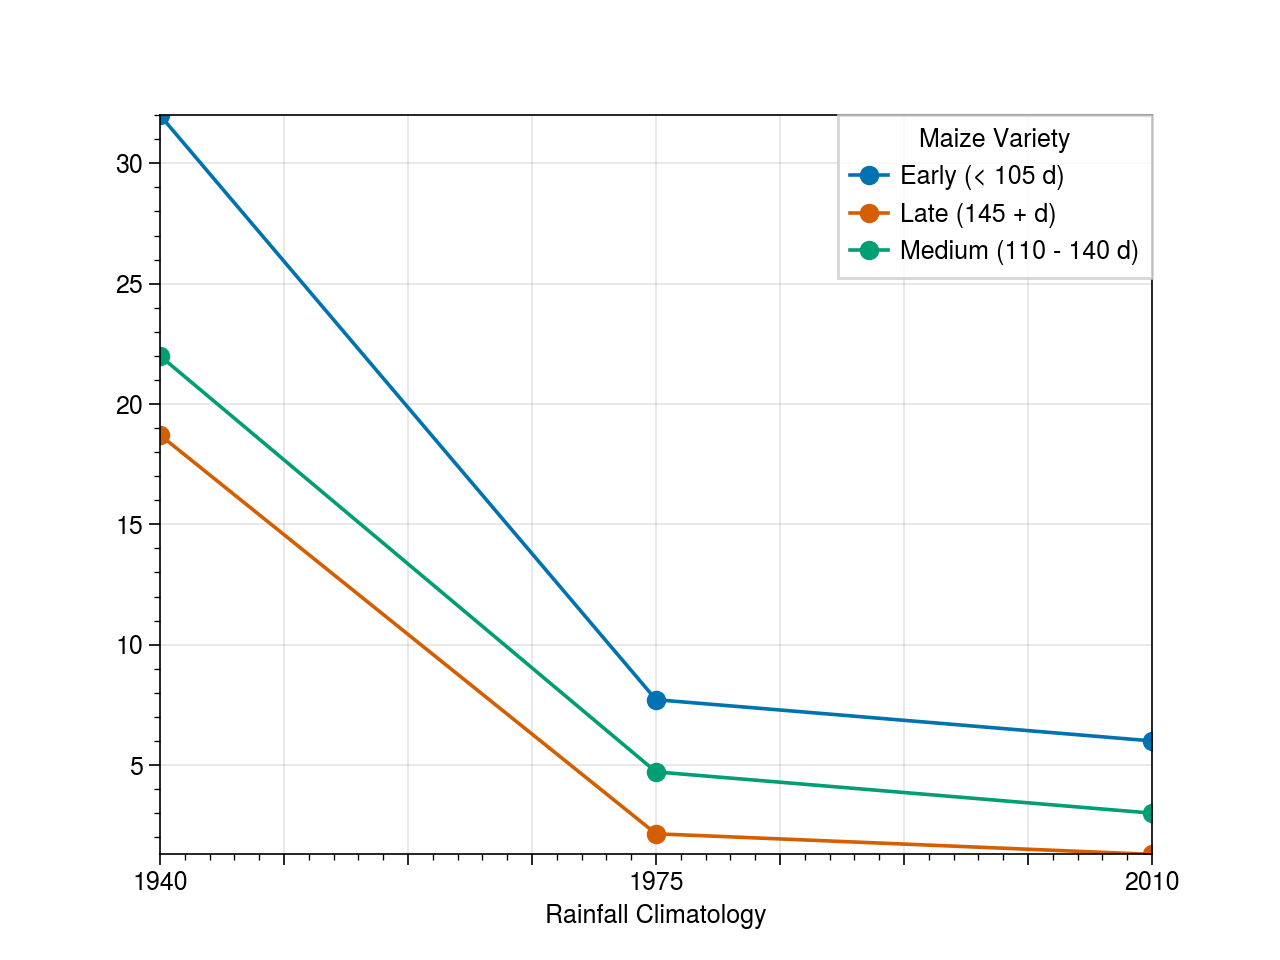

In [4]:
# Make line plot, and then make this line plot for different varieties


#table1['Probability of Crop Failure (%)'].plot(kind='bar')
#df_ = df.pivot(index='Probability of Crop Failure (%)', columns='Maize Variety', values='Rainfall Climatology')
df_ = df.pivot(index='Rainfall Climatology', columns='Maize Variety', values='Probability of Crop Failure (%)')
df_.plot(marker='o',markersize=6)
#table1['Average Yield (t/ha)'].plot()
#plt.show()

### Make a table of summary statistics

Put together table of summary statistics
TODO. Re-run with 10,000 simulations

Don't wan't to include 0s in Yield calculation.

What's below is for all the varieties together:

In [5]:
# What i had previously
# Average Yield - with or without 0s?

# without 0s - need to fill in 0s with nans
# for average yield need to take non-zero numbers
r0[r0 == 0] = np.nan
r1[r1 == 0] = np.nan
r2[r2 == 0] = np.nan
r1930[r1930 == 0] = np.nan

# need to use nan mean for Yield because 0s were turned into nans
y_0, y_1, y_2, y_1930 = np.nanmean(r0.Yield),np.nanmean(r1.Yield),np.nanmean(r2.Yield),np.nanmean(r1930.Yield)

# with 0s
#y_0, y_1, y_2 = r0.Yield.mean(), r1.Yield.mean(), r2.Yield.mean()
#y_1930 = r1930.Yield.mean()

# Average RF
rf_0 = r0.RF.mean()
rf_1 = r1.RF.mean()
rf_2 = r2.RF.mean()
rf_1930 = r1930.RF.mean()

# Percent of crop failure

# Turn nans back to zeros
r0 = r0.fillna(0)
r1 = r1.fillna(0)
r2 = r2.fillna(0)
r1930 = r1930.fillna(0)

c_0 = len(r0.loc[r0['Yield'] == 0].count(axis=1))/len(r0)*100
c_1 = len(r1.loc[r1['Yield'] == 0].count(axis=1))/len(r1)*100
c_2 = len(r2.loc[r2['Yield'] == 0].count(axis=1))/len(r2)*100
c_1930 = len(r1930.loc[r1930['Yield'] == 0].count(axis=1))/len(r1930)*100

In [6]:
# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Past climate','Unaltered climate','25% climate',  '50% climate']
rf = [rf_1930, rf_0, rf_1, rf_2] 
y = [y_1930, y_0, y_1, y_2] 
c = [c_1930, c_0, c_1, c_2] 

table1 = pd.DataFrame({'Rainfall Climatology':p_desc,
                       'Average Rainfall (mm)': rf,
                       'Average Yield (t/ha)': y,
                       'Probability of Crop Failure (%)':c})

table1 = table1.round({'Average Rainfall (mm)':1,'Average Yield (t/ha)':4,
             'Probability of Crop Failure (%)':2})
#table1.to_csv('table1.csv',sep=',')

table1


,Rainfall Climatology,Average Rainfall (mm),Average Yield (t/ha),Probability of Crop Failure (%)
0,Past climate,294.2,2.0632,0.19
1,Unaltered climate,323.5,1.7588,3.43
2,25% climate,292.8,1.5818,11.52
3,50% climate,232.8,1.2215,35.90


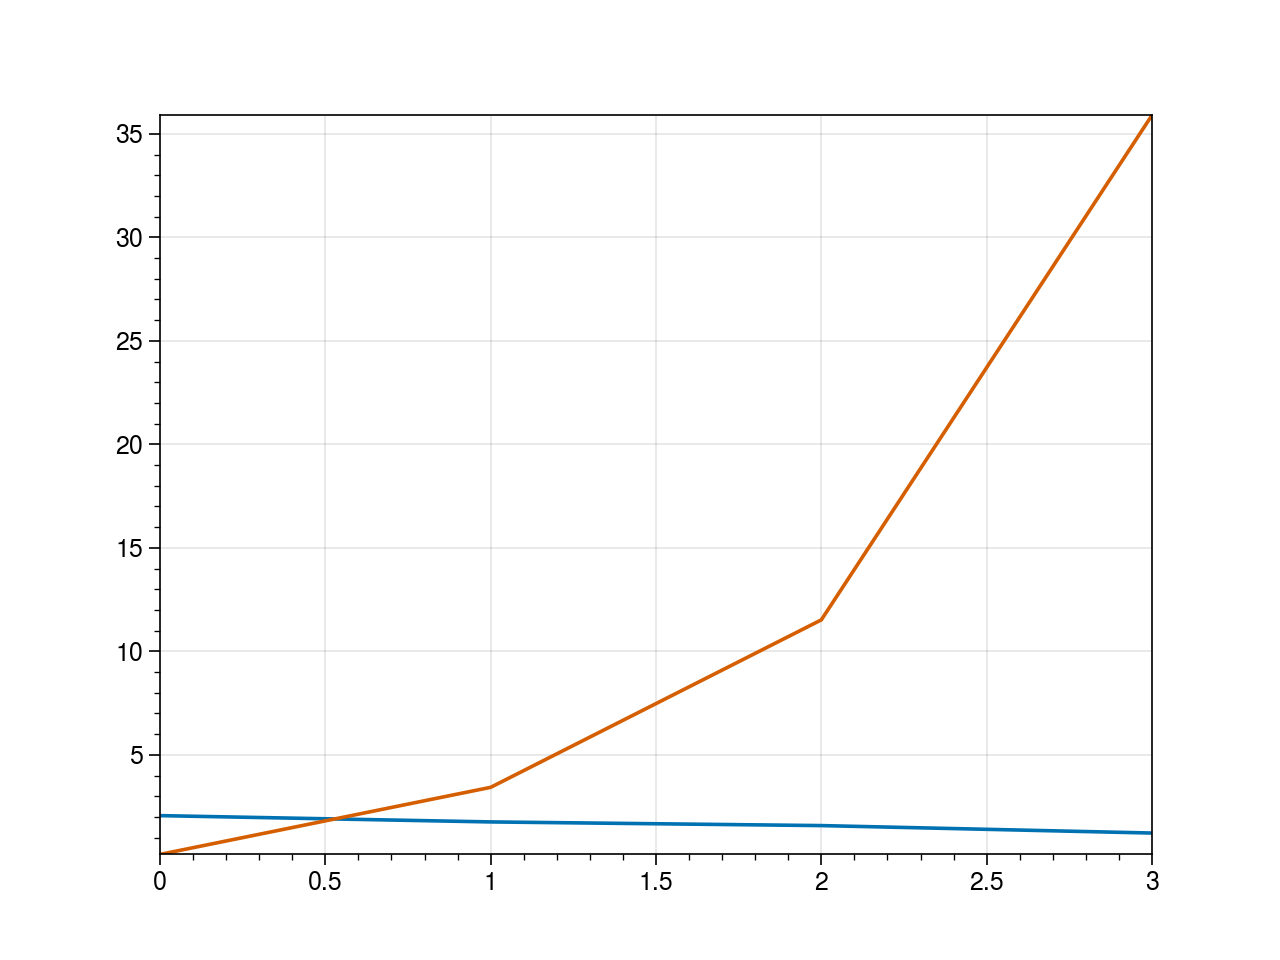

In [7]:
# Make line plot, and then make this line plot for different varieties

table1['Average Yield (t/ha)'].plot()
table1['Probability of Crop Failure (%)'].plot()
plt.show()
#table1['Probability of Crop Failure (%)'].plot(kind='bar')


## 5. Translate alphas and lambdas into coefficient of variation, c.v.  <a id='cv'></a>

See 1-rainfall-variability-stats notebook for more on this.

## 6. How do we make a more variable climate?  <a id='future'></a>

First idea: Increase alpha by 15%; decrease lambda by 15%

In [35]:
# normal rainfall

def run(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 60 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return output, avg_stress, total_stress, total_rf

output, avg_stress, total_stress, total_rf = run()


NameError: name 'i' is not defined

### Change climate here

To go backwards in the climate space, we want to go from 1 and decrease this number for alpha and increase for lambda, so that is:

#### Method 1:
Alphas:
- Historic: 5.84
- Present: 9.44
- Calculate percent change
- 61.6438% increase
- 38.1356% decrease 

**For A_FAC use**: 1*(1-0.38) = 0.62

Lambdas:
- Historic: 0.459
- Present: 0.302
- 34.2048% decrease
- 51.9868% increase

**For L_FAC use**: 1*(1+.5199) = 1.5199 (Honestly not sure if the L_FAC is correct.)

#### Method 2: Use regression line from rainfall stats for values (estimated)
For short rains:
- 1940: a = 5.5 (1-(9.44-5.5)/9.44))=0.583, l = 0.42 (1-(0.302-0.42)/3.02)) = 1.39
- 1975: a = 8, l = 0.35 (1-(9.44-8)/9.44))=0.847, l = 0.42 (1-(0.302-0.35)/3.02)) = 1.159
- 2010: a = 10.5, l = 0.28 (1-(9.44-10.5)/9.44))=1.112, l = 0.42 (1-(0.302-0.42)/3.02)) = 0.927


In [21]:
#A_FAC = 0.583
#L_FAC = 1.39
#A_FAC = 0.847
#L_FAC = 1.159
#A_FAC = 1.112
#L_FAC = 0.927
#A_FAC=1
#L_FAC=1
A_FAC=1.75
L_FAC=0.25

In [22]:
# copying the whole climate object

#%% Climate Class Definition
from math import exp
import numpy as np
from numpy.random import exponential, uniform

default_climate = {
    'alpha_r': [10.0] * 12,
    'lambda_r': [0.25] * 12,
    'ET_max': 6.5
}

from datetime import timedelta, datetime

datetimes = np.arange(
    datetime(2018,1,1), datetime(2019,1,1), timedelta(days=1)
    ).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

# Should we rename this?
class Climate():

    """ Creates a years worth of daily rainfall timeseries for use in ecohydrological modeling

    Usage: climate = Climate(alpha_r, lambda_r, ET_max)

        alpha_r = average storm depth [mm]
        lambda_r = storm frequency [day^-1]
      
    Default values:
        alpha_r = 10
        lambda_r = 0.25
        t_seas = 180
        ET_max = 6.5

    Note: lambda must either be a single value (constant rainfall probability all season),
    or have length of tseas (discrete rainfall probabilities each day.

    """
    def __init__(self, alpha_r=[10.0] * 12, lambda_r=[0.25] * 12, ET_max=6.5, **kwargs):
        
       
        # Unpack the dictionary:
        self.ET_max = ET_max
        
        # Check to ensure that lambda_r is either:
        # 1. a scalar, which means we have constant climate parameters
        # 2. has length of 365, which means we have specified daily values.
        # 3. has length of 12, which means we have specified monthly values.
        if isinstance(lambda_r, (float, int)):
            if isinstance(alpha_r, (float, int)):
                # We have a constant value:
                lambda_r_list = [lambda_r] * 365
                alpha_r_list = [alpha_r] * 365
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        elif len(lambda_r) == 365:
            if len(alpha_r) == 365:
                lambda_r_list = lambda_r
                alpha_r_list = alpha_r
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        elif len(lambda_r) == 12:
            if len(alpha_r) == 12:
                # We have monthly values (remember that python is zero-indexed)
                lambda_r_list = np.array(
                    [lambda_r[month_value-1] for month_value in month_value_by_day]
                    )
                alpha_r_list = np.array(
                    [alpha_r[month_value-1] for month_value in month_value_by_day]
                    )
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        else:
            raise ValueError(
                "lambda_r & alpha_r values should be a constant, have length of t_sim, or have length of 12"
            )
      
        # Set the rainfall parameters for this instance
        self.alpha_r = alpha_r_list*A_FAC
        self.lambda_r = lambda_r_list*L_FAC
        
        # Use the static method, generate, to create this instance's rainfall.
        self.rainfall = self.generate(self.alpha_r, self.lambda_r)

        # Assign any other passed parameters (e.g. site, etc...)
        for key, value in kwargs.items():
            self.key = value


    def calc_E(self, s, q=1.5, LAI=None, sh=None): 
        """ Determines the daily evaporation as a function of relative soil moisture

        Usage: calc_E(s)

            TODO: Update parameters.

            s = relative soil moisture [0-1]
            E_max_p = E_max * exp(-k * LAI)
            E = E_max * [(s-sh)/(1-sh)]^q

        """
        if LAI == None:
            raise ValueError("Climate calc_E expects LAI that's not None.")

        k = 0.5
        E_max_p = self.ET_max*exp(-k*LAI) 
        if s >= sh:
            return pow((s-sh)/(1-sh), q)*E_max_p
        else:
            return 0

    @staticmethod # Static methods can be called without instancing the class.
    def generate(alpha_r, lambda_r, t_sim=365, doy_start=1):
        """ Makes a time series of rainfall based on parameters

        Usage:
            generate(alpha_r, lambda_r, t_seas)

            alpha_r = average storm depth [mm]
            lambda_r = storm frequency [day^-1]
            t_seas = lenght of growing season [days]

        Note: lambda must either be a single value (constant rainfall probability all season),
        or have length of tseas (discrete rainfall probabilities each day.

        """
        # Force doy to be in [1,365]:
        doys = np.arange(doy_start, doy_start + t_sim)
        while (doys - 365 > 0).any() == True:
            doys = doys - 365 * ((doys - 365) > 0)

        amounts = [exponential(scale=alpha_r[doy-1], size=1)[0] for doy in doys]
        rain_days = [(uniform(low=0, high=1, size=1) <= lambda_r[doy-1] ).astype(int) for doy in doys]
        return np.multiply(amounts, [v[0] for v in rain_days])



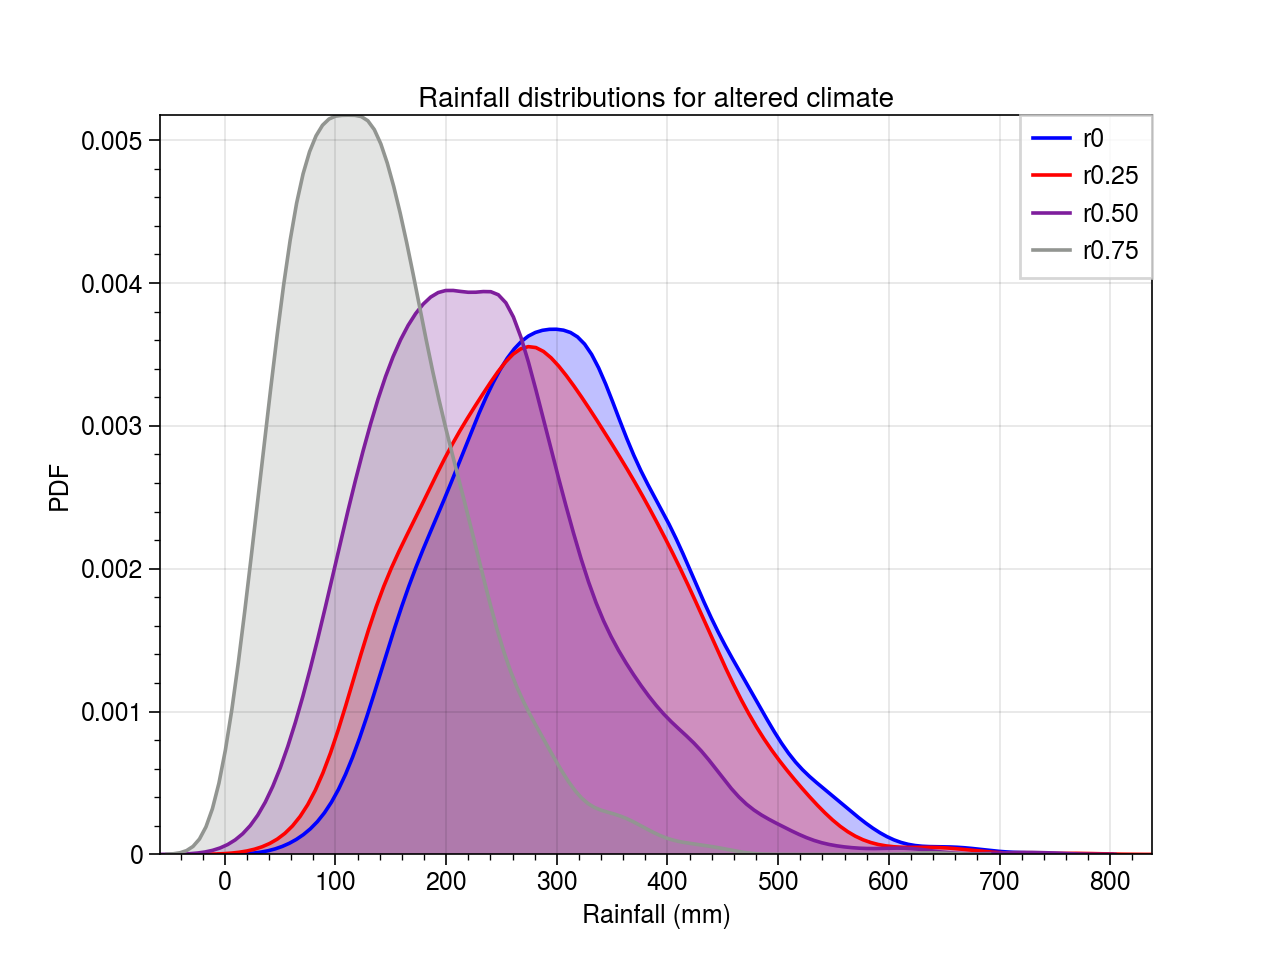

In [35]:
# altered rainfall

# used this to save rainfall ouputs
# can re-import them to make the plot
#output_c, avg_stress_c, total_stress_c, total_rf_c = run()

# Let's get a PDF of the rainfall

sns.kdeplot(r0.RF, shade=True, color="blue", label='r0')
sns.kdeplot(r1.RF, shade=True, color="red", label='r0.25')
sns.kdeplot(r2.RF, shade=True, color="purple", label='r0.50')
sns.kdeplot(r3.RF, shade=True, color="gray", label='r0.75')

plt.xlabel('Rainfall (mm)')
plt.ylabel('PDF')
plt.title('Rainfall distributions for altered climate')
plt.legend()

#plt.savefig('../output/2-rainfall-variability/rf_PDFs.png')


In [25]:
# let's get the summary stats of all these vars
# total_rf

# df = pd.DataFrame([total_rf, total_rf_a, total_rf_b, total_rf_c], index =['r0','r0.25','r0.5','r0.75']).T
# stats = df.describe()

# # add some additional stats

# stats.loc['IQR'] = stats.loc['75%'] - stats.loc['25%'] # appending interquartile range instead of recalculating it
# stats = stats.append(df.reindex(stats.columns, axis=1).agg(['skew', 'mad', 'kurt']))
# stats

In [26]:
# cool, let's output these variables and save the summary stats

# df.to_csv('../output/2-rainfall-variability/rainfall_ts.csv',sep=',')
# stats.to_csv('../output/2-rainfall-variability/summary_stats.csv',sep=',')


## 7. Now make cultivars figure  <a id='cultis'></a>

In [27]:
# Have to re-create the run_model function so that in crop.calc_dstress it uses my evolved_calc_yield function
# OL JOGI FARM 
def run_model(n_sim = 500, station = 'JACOBSON FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 60 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return x, total_rf


In [30]:
# Now I have to re-run the simulations using the max yields from this relationship

varieties = np.arange(75,180,5) # 21 is a better number to work with because it divides by three
len(varieties)

result = []

for i in varieties:
    # note: bumping up to 200 sims per cultivar type takes several minutes to run
    # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
    data, rf = run_model(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
    df['RF'] = rf
    df['Cultivar'] = i
    result.append(df)
    
result = pd.concat(result)
result

,AvgStress,DynamicStress,Yield,RF,Cultivar
0,0.103033,0.197956,1.368117,242.071375,75
1,0.917555,1.000000,0.000000,18.656933,75
2,0.716193,1.000000,0.000000,67.193724,75
3,0.528845,1.000000,0.000000,112.568736,75
4,0.467744,0.820301,0.306528,210.055398,75
...,...,...,...,...,...
95,0.816743,1.000000,0.000000,98.614569,175
96,0.780408,1.000000,0.000000,149.086486,175
97,0.593129,0.963434,0.130939,235.505587,175
98,0.665942,1.000000,0.000000,244.464735,175


In [31]:
# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this

def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"
    
for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

result_safe = result


In [32]:
result

,AvgStress,DynamicStress,Yield,RF,Cultivar,Category
0,0.103033,0.197956,1.368117,242.071375,75,Early (< 105 d)
1,0.917555,1.000000,0.000000,18.656933,75,Early (< 105 d)
2,0.716193,1.000000,0.000000,67.193724,75,Early (< 105 d)
3,0.528845,1.000000,0.000000,112.568736,75,Early (< 105 d)
4,0.467744,0.820301,0.306528,210.055398,75,Early (< 105 d)
...,...,...,...,...,...,...
95,0.816743,1.000000,0.000000,98.614569,175,Late (145 + d)
96,0.780408,1.000000,0.000000,149.086486,175,Late (145 + d)
97,0.593129,0.963434,0.130939,235.505587,175,Late (145 + d)
98,0.665942,1.000000,0.000000,244.464735,175,Late (145 + d)


In [33]:
# Save the results I got to csvs

#result.to_csv('../output/2-rainfall-variability/t2010_output.csv',sep=',') # tsignifies trend line
#result_safe.to_csv('../output/2-rainfall-variability/r0_output.csv',sep=',')
#result025.to_csv('../output/2-rainfall-variability/r25_output.csv',sep=',')
#result05.to_csv('../output/2-rainfall-variability/r50_output.csv',sep=',')
#result_safe.to_csv('../output/2-rainfall-variability/r1930_output.csv',sep=',')
#result.to_csv('../output/2-rainfall-variability/r75_output.csv',sep=',')

## Make three (seperate) plots

Would want to re-import the results data before running this. 
Also might want the subplots figure to work with one uniform colorbar between all of them; potentially not a trivial task. 

(0.0, 700.0)

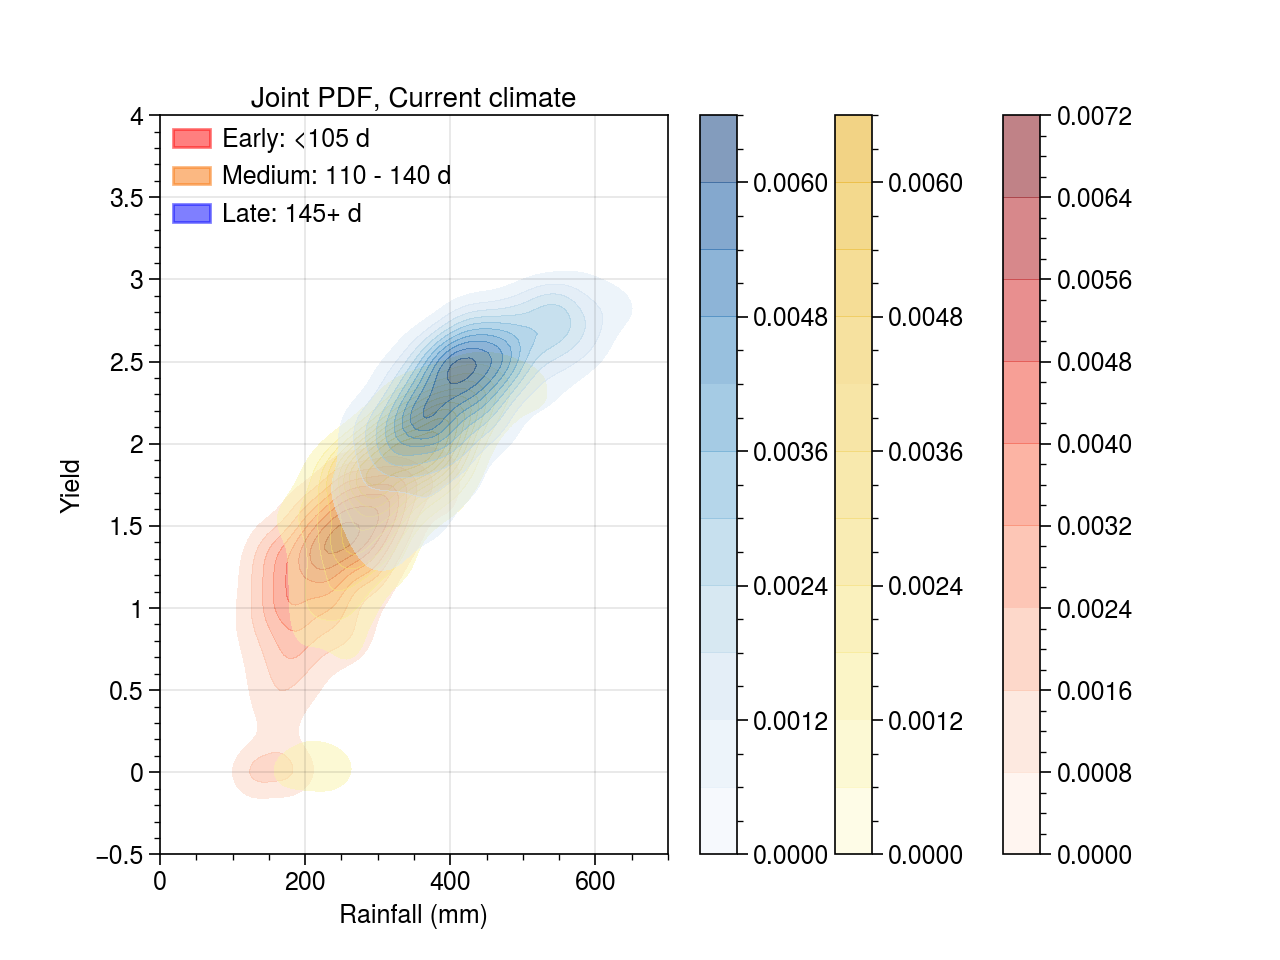

In [9]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
result=r0

########## Plot 1

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots() #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, Current climate')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)

(0.0, 700.0)

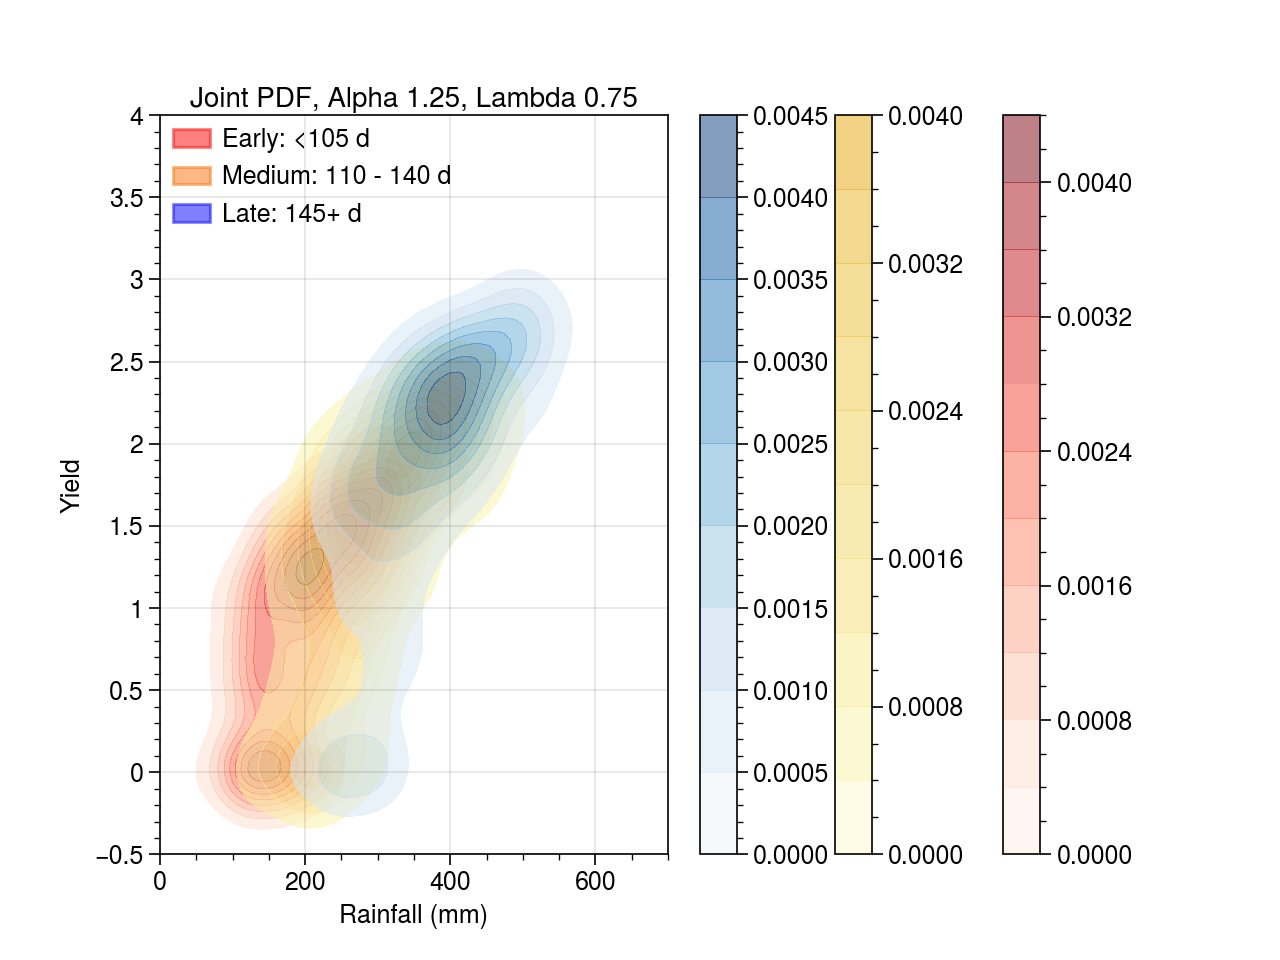

In [10]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


########## Plot 2
result = r1

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots() #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, Alpha 1.25, Lambda 0.75')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)

(0.0, 700.0)

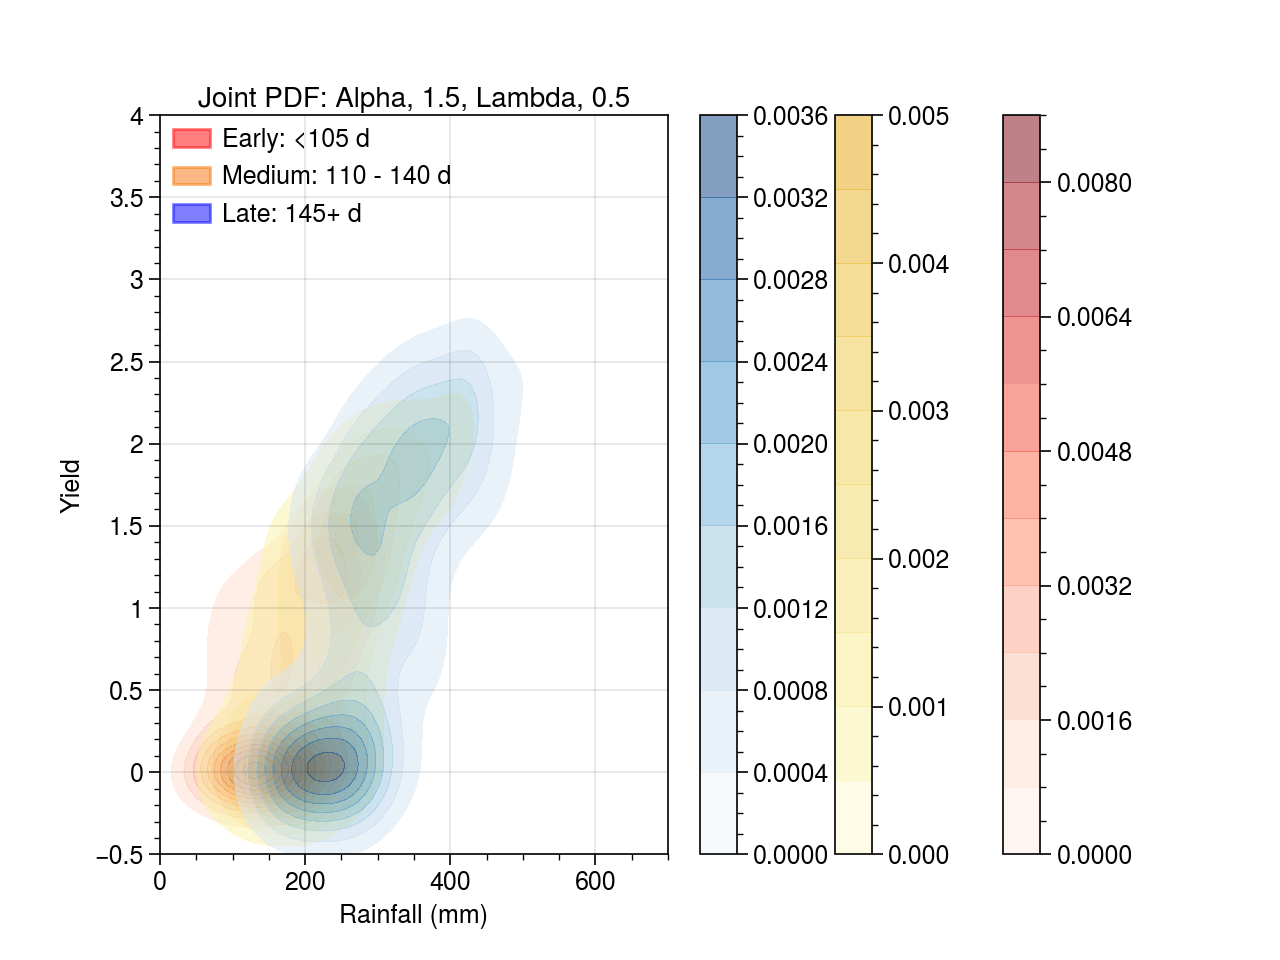

In [11]:
########## Plot 3
result = r2

#plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF: Alpha, 1.5, Lambda, 0.5')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)
#plt.legend(['Early (<105 d)', 'Medium (110 - 140 d)', 'Late (145+ d)'])

### Notes to self about climate alterations

Lambda: probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month.
- So a lambda of 0.10 which is 1/10 means it rains once every 10 days. 

Lambda does change by season, and what we do is increase or decrease the lambda by the same amount each season. Could maybe do this more sophisticated but for now it’s fine. 

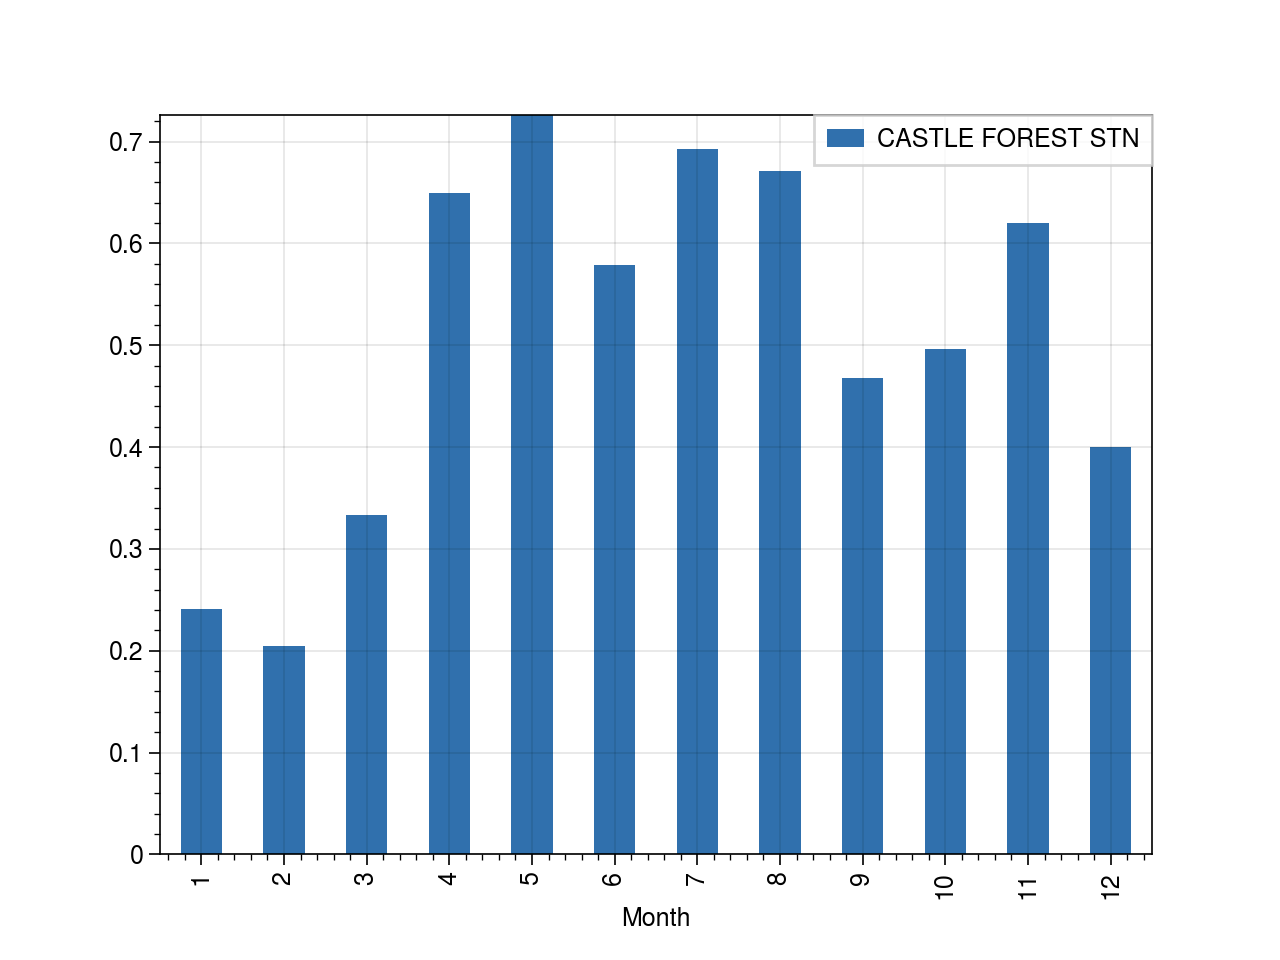

How lambda is changing over time:

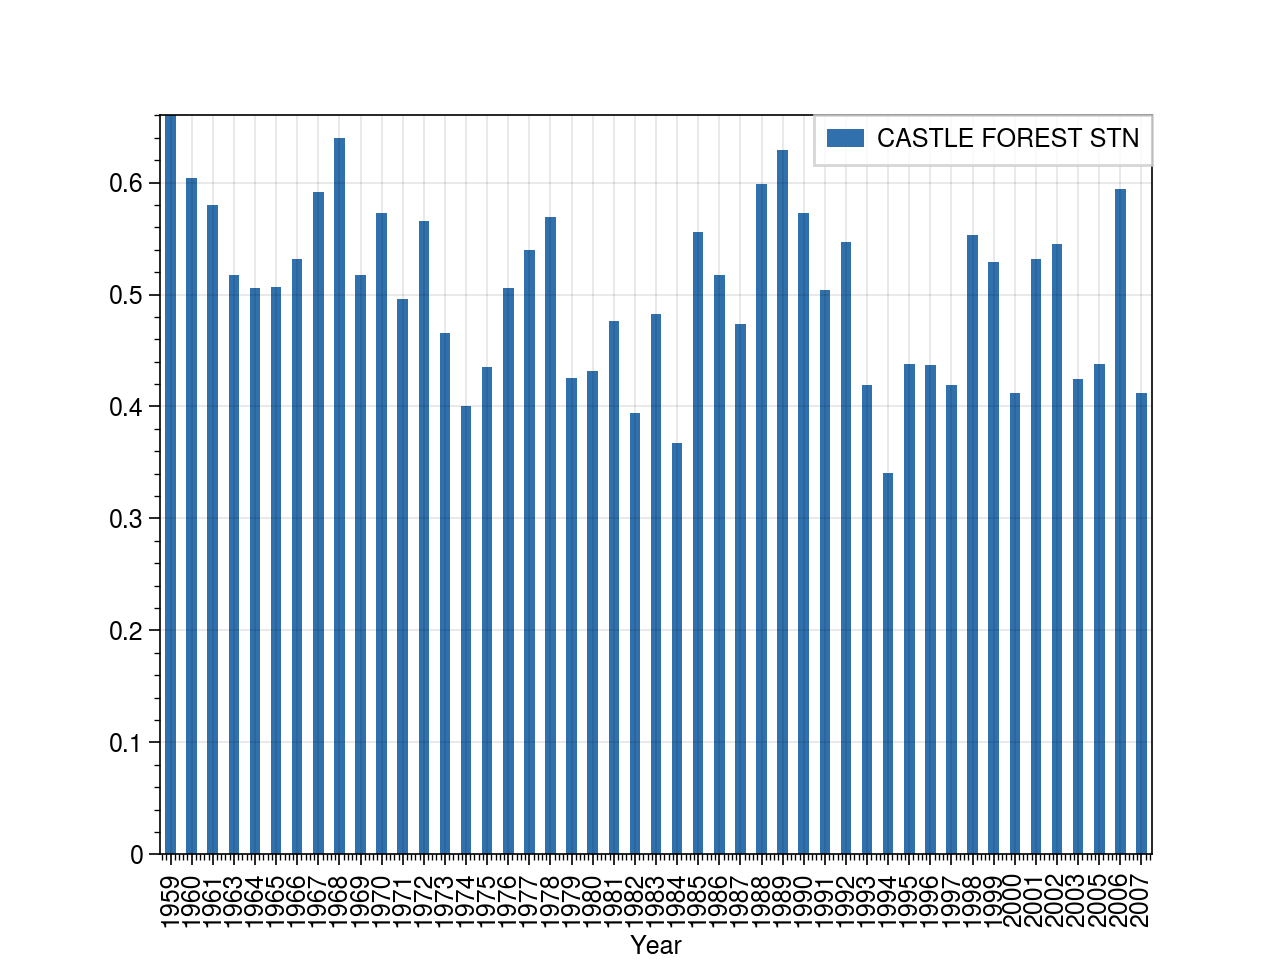

Take the average of the first 3-5 years of the record and compared that to the last 3-5 years of the record. Want them to have similar variances. The number of x years selected is determined by having similar variances.


## 8. Presentation Figures  <a id='prez'></a>

In [3]:
import numpy as nop
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Uncomment for black background figure
plt.rcParams.update({
    "grid.color": "white",
    'hatch.color': 'k',
    "lines.color": "white",
    "patch.edgecolor": "black",
    'patch.facecolor': "black", # ([0, 1, 1])
    'grid.alpha': 0.4,
    "text.color": "lightgray",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# To make the plots look better, one option is to set the alpha to 0.9, but then we can really only see the late 
# maturing crop clearly



(0, 700)

<Figure size 8000x8000 with 0 Axes>

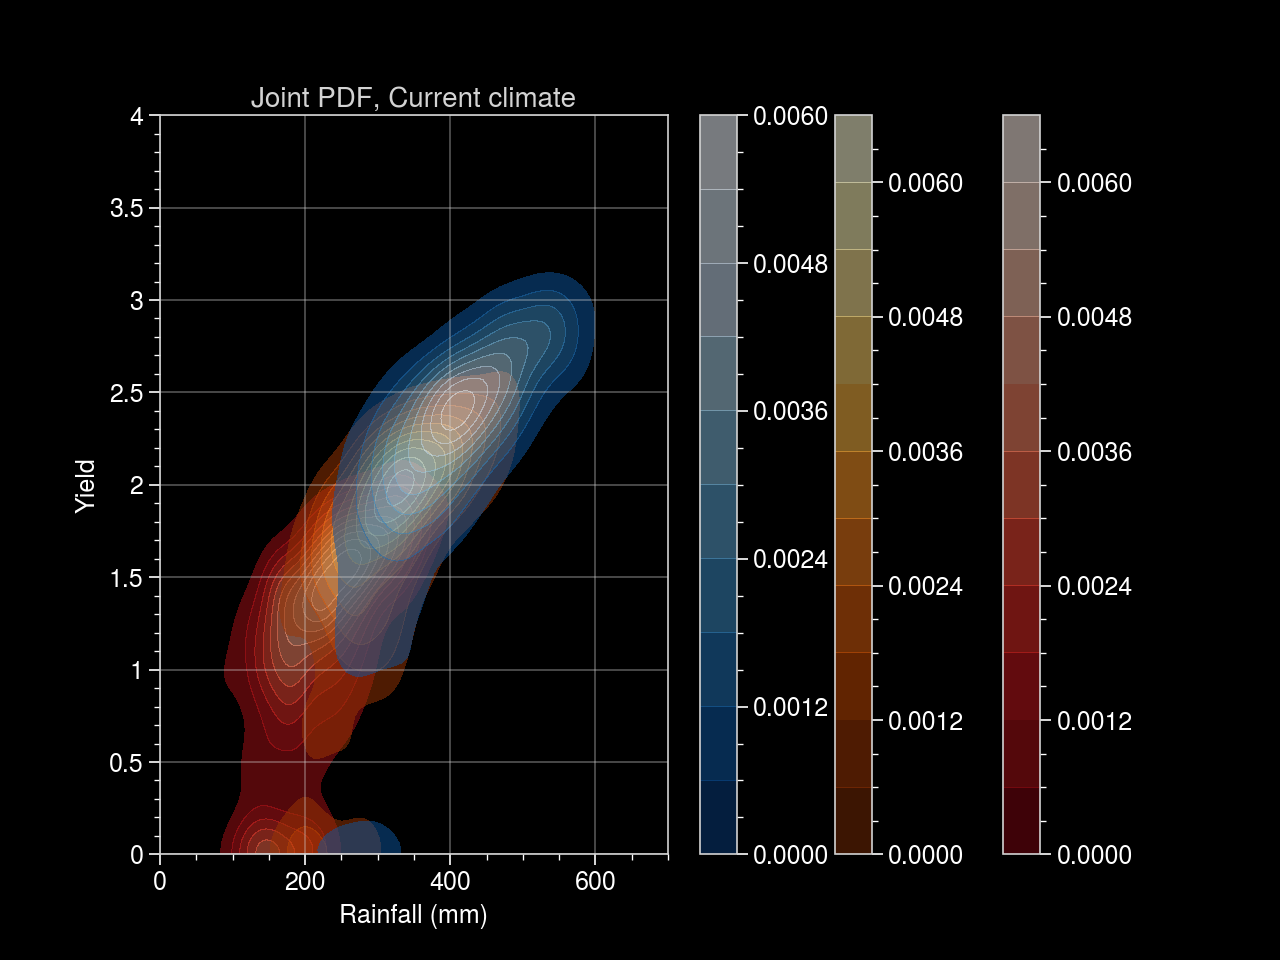

In [43]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

plt.figure(figsize=(10, 10), dpi=800, facecolor='w', edgecolor='k')
result=r0

########## Plot 1

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, ax = plt.subplots() #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
ax1 = sns.kdeplot(early.RF, early.Yield, alpha=0.5,cmap="reds_r",cut=True,
                  shade=True, shade_lowest=False, cbar=True) 
ax1 = sns.kdeplot(med.RF, med.Yield, alpha=0.5, cmap="ylorbr_r", cut=True, #ylorbr_r 3purples
                  shade=True, shade_lowest=False, cbar=True)
ax1 = sns.kdeplot(late.RF, late.Yield, alpha=0.5, cmap="blues_r",cut=True, # blues_r
                  shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, Current climate')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
#plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(0,4)
plt.xlim(0,700)

(0, 700)

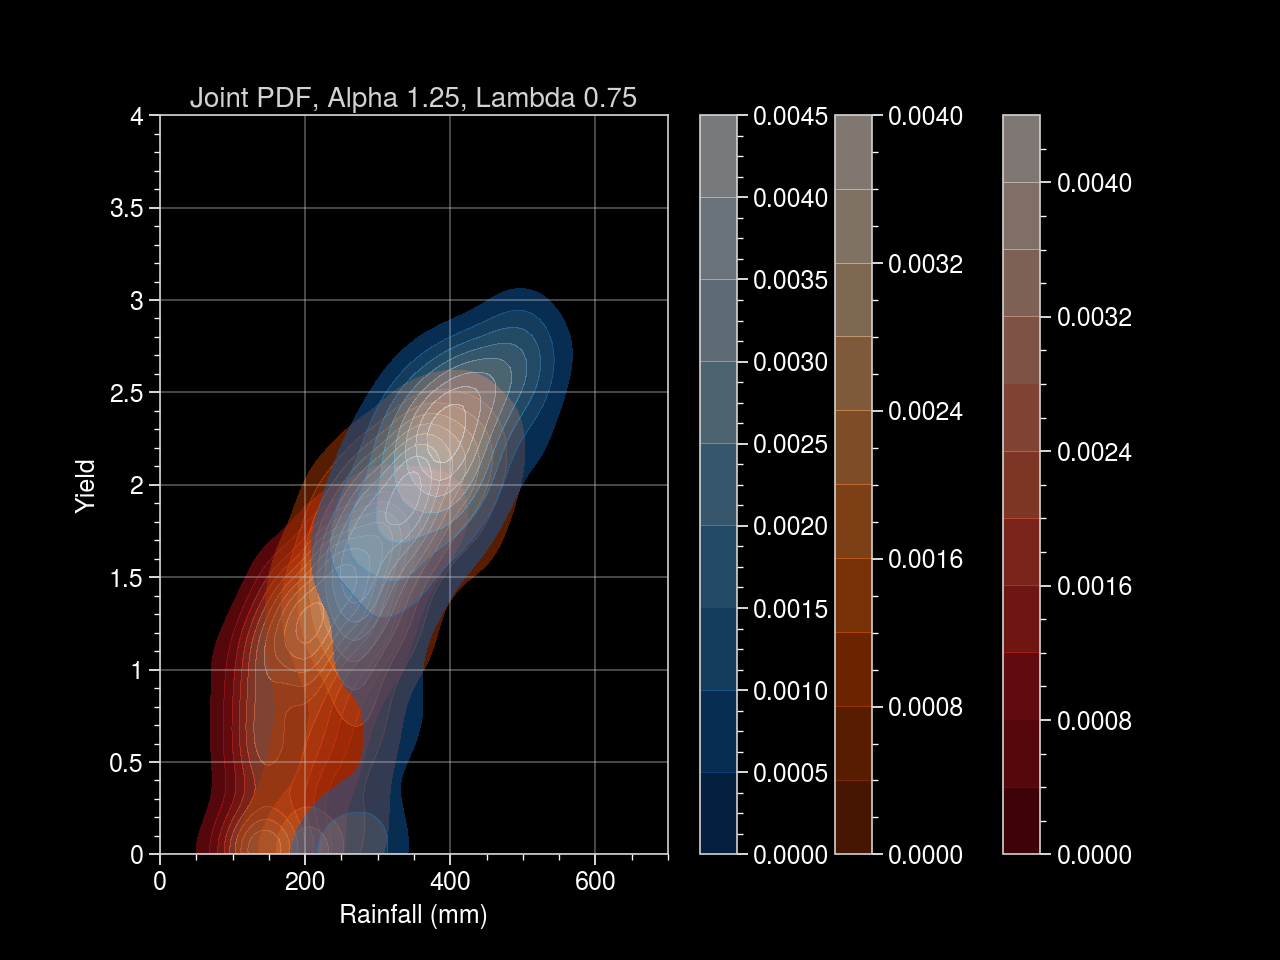

In [28]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


########## Plot 2
result = r1

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots() #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds_r", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="oranges_r", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues_r", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, Alpha 1.25, Lambda 0.75')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
#plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(0,4)
plt.xlim(0,700)

(0, 700)

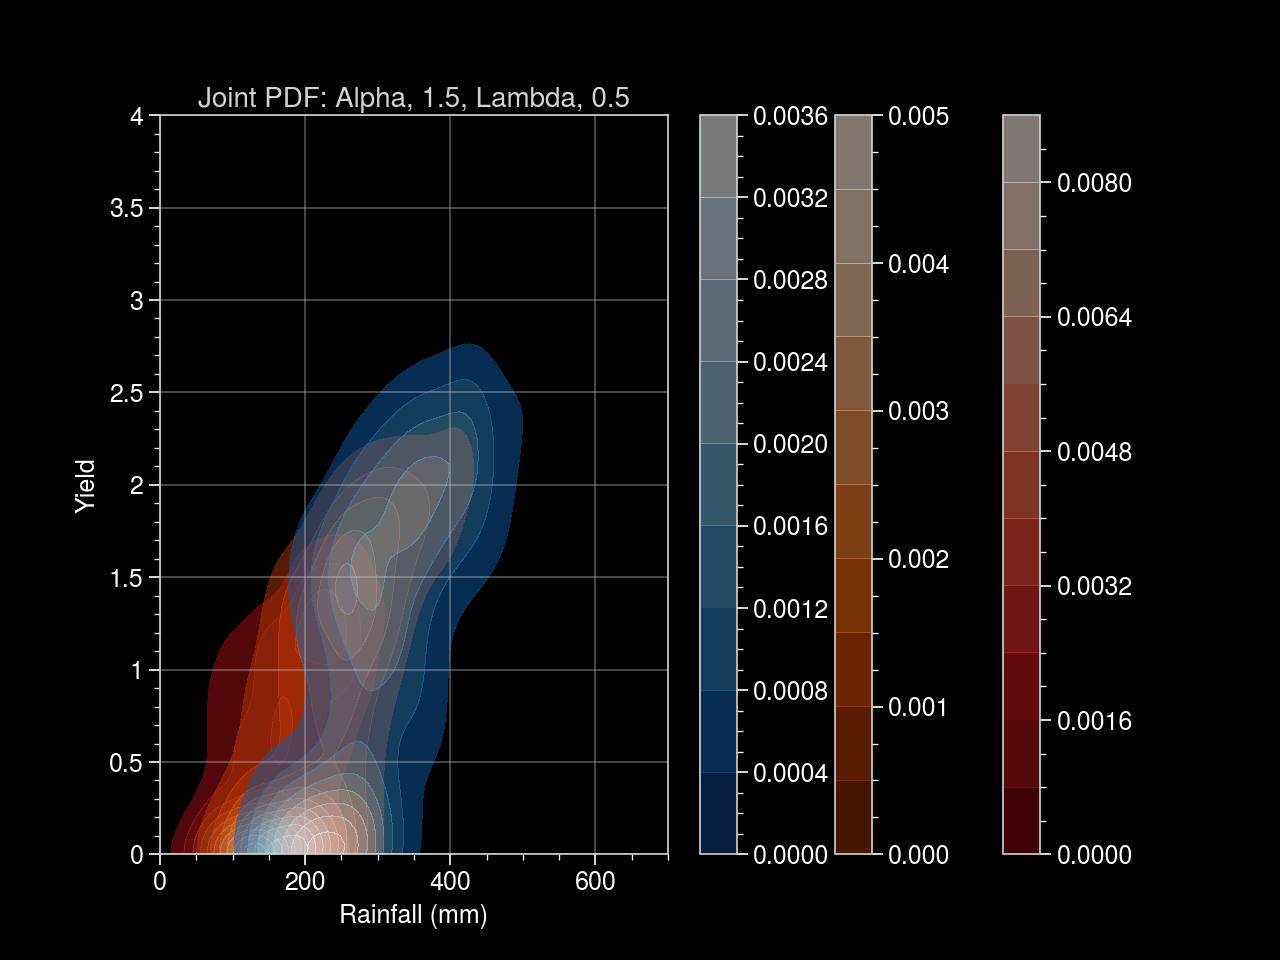

In [29]:
########## Plot 3
result = r2

#plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds_r", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="oranges_r", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues_r", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF: Alpha, 1.5, Lambda, 0.5')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
#plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(0,4)
plt.xlim(0,700)
#plt.legend(['Early (<105 d)', 'Medium (110 - 140 d)', 'Late (145+ d)'])

In [ ]:
# actually a little complicated to figure out the one colorbar
# in part because I am using plt not plot. Could post on proplot readthedocs for help
# https://proplot.readthedocs.io/en/latest/colorbars_legends.html#ug-cbars-axes

# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

plt.figure(figsize=(10, 10), dpi=800, facecolor='w', edgecolor='k')
result=r0

########## Plot 1

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
ax1 = sns.kdeplot(early.RF, early.Yield, alpha=0.5,cmap="reds_r",cut=True,
                  shade=True, shade_lowest=False, cbar=True, ax=ax1) 
ax1 = sns.kdeplot(med.RF, med.Yield, alpha=0.5, cmap="ylorbr_r", cut=True, #ylorbr_r 3purples
                  shade=True, shade_lowest=False, cbar=True, ax=ax1)
ax1 = sns.kdeplot(late.RF, late.Yield, alpha=0.5, cmap="blues_r",cut=True, # blues_r
                  shade=True, shade_lowest=False, cbar=True, ax=ax1) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, Current climate')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
#plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(0,4)
plt.xlim(0,700)

(0, 700)

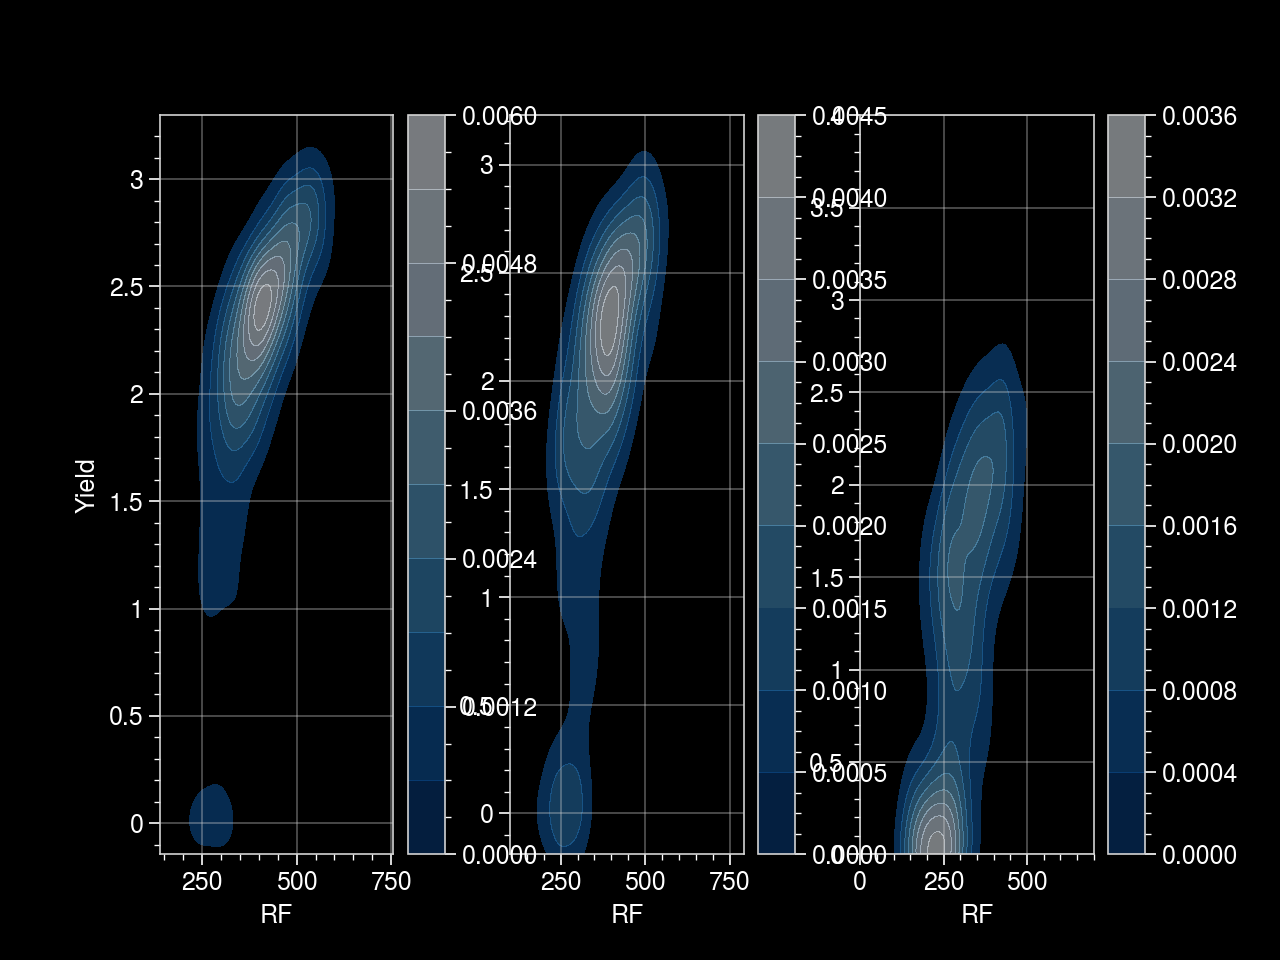

In [57]:
# so instead just going to do for one variety
# giving up on this

# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(10, 10), dpi=800, facecolor='w', edgecolor='k')

# Subset the iris dataset by species
early = r0.query("Category == 'Late (145 + d)'")
med = r1.query("Category == 'Late (145 + d)'")
late = r2.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots(nrows=1, ncols=3) #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
sns.kdeplot(early.RF, early.Yield, alpha=0.5,cmap="blues_r",cut=True,
                  shade=True, shade_lowest=False, cbar=True, ax=axs[0]) 
sns.kdeplot(med.RF, med.Yield, alpha=0.5, cmap="blues_r", cut=True, #ylorbr_r 3purples
                  shade=True, shade_lowest=False, cbar=True, ax=axs[1])
sns.kdeplot(late.RF, late.Yield, alpha=0.5, cmap="blues_r",cut=True, # blues_r
                  shade=True, shade_lowest=False, cbar=True, ax=axs[2]) #greens

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
#plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(0,4)
plt.xlim(0,700)

#for ax, title in zip(axs, ['Joint PDF, Current climate', '2D dataset #2']):
#    ax.format(xlabel='xlabel', title=title)

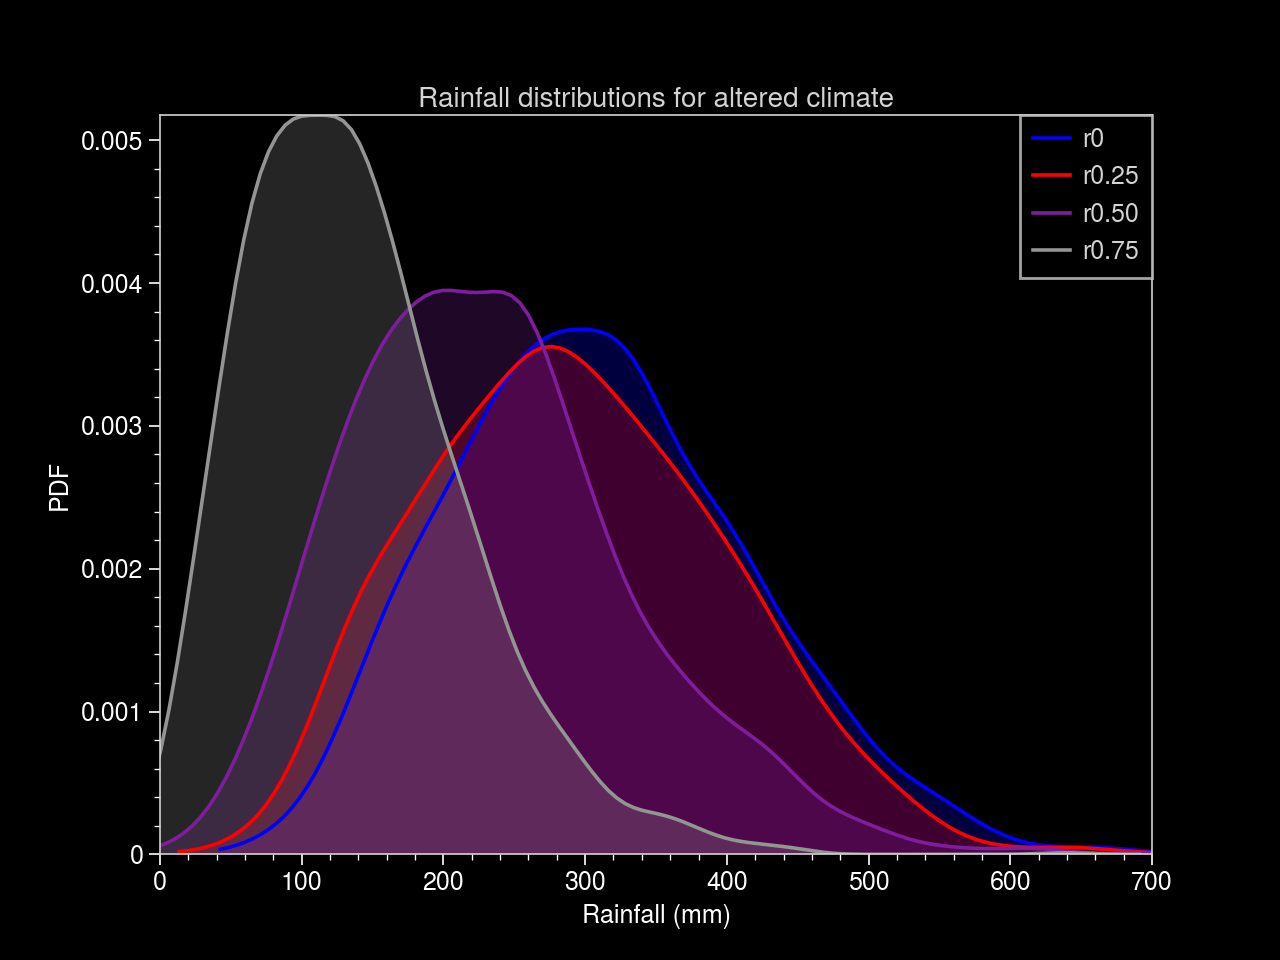

In [51]:
# Uncomment for black background figure
plt.rcParams.update({
    "grid.color": "black",
    'hatch.color': 'k',
    "lines.color": "black",
    "patch.edgecolor": "white",
    'patch.facecolor': ([0, 1, 1]),
    'grid.alpha': 0,
    "text.color": "lightgray",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "black",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# altered rainfall

# used this to save rainfall ouputs
# can re-import them to make the plot
#output_c, avg_stress_c, total_stress_c, total_rf_c = run()

# Let's get a PDF of the rainfall

sns.kdeplot(r0.RF, shade=True, color="blue", label='r0', cut=True)
sns.kdeplot(r1.RF, shade=True, color="red", label='r0.25', cut=True)
sns.kdeplot(r2.RF, shade=True, color="purple", label='r0.50', cut=True)
sns.kdeplot(r3.RF, shade=True, color="gray", label='r0.75')

plt.xlabel('Rainfall (mm)')
plt.ylabel('PDF')
plt.title('Rainfall distributions for altered climate')
plt.legend()

plt.xlim(0,700)
#plt.savefig('../output/2-rainfall-variability/rf_PDFs_prez.png')
